**Байесовский классификатор: квадратичный дискриминант**

Евгений Борисов <esborisov@sevsu.ru>

SciKit-Learn : Linear and Quadratic Discriminant Analysis   
https://scikit-learn.org/stable/modules/lda_qda.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
import pandas as pd
np.set_printoptions(precision=2)

##  загружаем данные 

In [3]:
from sklearn.datasets import make_blobs

X,y = make_blobs( n_samples=500, centers=2, cluster_std=[1.8, 2.1,] )
display( X.shape, y.shape )

(500, 2)

(500,)

### делим датасет

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, )

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((250, 2), (250,), (250, 2), (250,))

In [5]:
del X, y

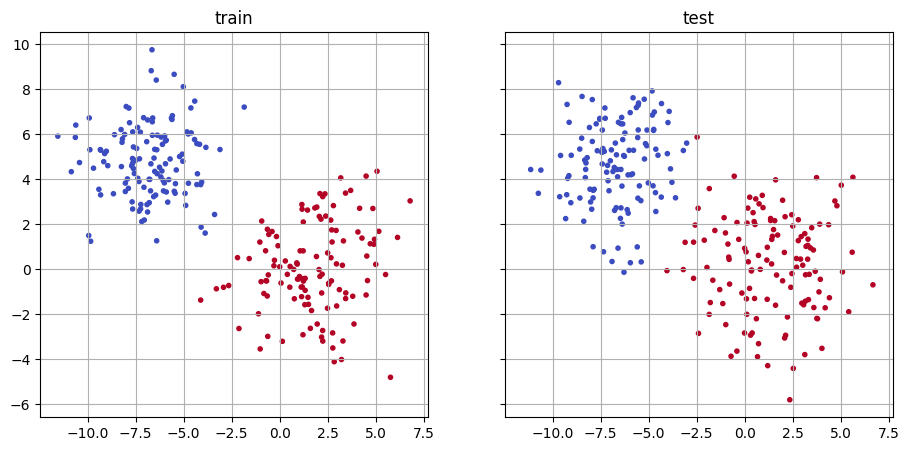

In [6]:
fig,ax = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(11,5),)

ax[0].scatter(
    x='x', y='y', c='label',marker='.', cmap='coolwarm'
    ,data=pd.DataFrame(np.hstack([X_train,y_train.reshape(-1,1)]),columns=['x','y','label'])
)
ax[0].set_title('train')
ax[0].grid()

ax[1].scatter(
    x='x', y='y', c='label',marker='.', cmap='coolwarm' # cmap='viridis_r'  
    ,data=pd.DataFrame(np.hstack([X_test,y_test.reshape(-1,1)]),columns=['x','y','label'])
)
ax[1].set_title('test')
ax[1].grid()

##  классификатор

__квадратичный дискриминант__


$$ 
a(u|X,Y,\lambda) = \underset{y\in Y}{\operatorname{argmax}} 
\left[ \ln(\lambda_y P_y) - \frac{1}{2} (u - \mu_y) \Sigma_y^{-1} (u-\mu_y)^T 
+  \frac{1}{2} \ln( |\Sigma_y| ) \right] 
$$




$\lambda_y$ - штраф за ошибочную классификацию объекта класса y;   
$P_y$ - априорная вероятность класса y (доля объектов класса y) ;   
$\mu_y$ - мат.ожидание для класса y ;   
$\Sigma_y$ -  матрица ковариации класса y ;

In [7]:
class QuadDiscriminantClassifier:
    
    def __init__(self,):
        self._mu = np.array([])
        self._cov = []
        self._icov = []
        self._coef = []
        
    def fit(self,X,target,lmbd=[]):
        assert len(X)>0
        assert len(X)==len(target)
        classes = sorted(set(target))
        lmbd = lmbd if len(lmbd)>0 else np.ones(len(classes))
        assert len(classes)==len(lmbd)
        apriori_prob = np.array([ (target==c).sum()/len(target) for c in classes ] )
        self._coef = np.log( lmbd*apriori_prob )
        self._mu = np.vstack( [ X[target==c,:].mean(axis=0) for c in classes ] )
        self._cov = [ np.cov(X[target==c,:].T) for c in classes ] # матрица ковариаций классов
        self._icov = [ np.linalg.inv(self._cov[c]) for c in classes ] # обратная матрица ковариаций классов
        return self
    
    def score(self,u):
        assert len(u)>0
        assert len(self._icov)>0
        assert self._icov[0].shape[0]==u.shape[1]
        
        d = [ u - self._mu[[c],:] for c in range(len(self._mu)) ]

        return np.vstack([
                self._coef[[c]]
                - np.diag( d[c].dot(self._icov[c]).dot(d[c].T) )/2.
                + np.log(np.linalg.norm(self._cov[c]))/2.
            for c in range(len(self._mu))
        ]).T
    
    def predict(self,u):
        return np.argmax( self.score(u),axis=1 )
    

## тестируем

In [8]:
model = QuadDiscriminantClassifier().fit(X_train,y_train,)

In [9]:
# u = X_train[:5,:]
# model.score(u)

In [10]:
from sklearn.metrics import classification_report

predicted = model.predict(X_test)
print( classification_report(y_test,predicted) )

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       122
           1       1.00      0.99      1.00       128

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



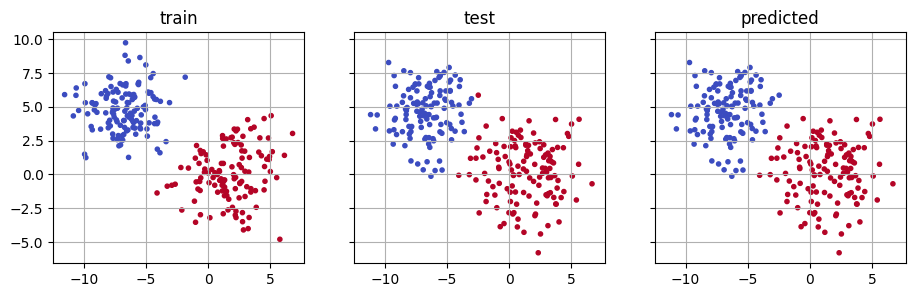

In [11]:
fig,ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(11,3),)

ax[0].scatter(
    x='x', y='y', c='label',marker='.', cmap='coolwarm',
    data=pd.DataFrame(np.hstack([X_train,y_train.reshape(-1,1)]),columns=['x','y','label'])
)
ax[0].set_title('train')
ax[0].grid()

ax[1].scatter(
    x='x', y='y', c='label',marker='.', cmap='coolwarm', 
    data=pd.DataFrame(np.hstack([X_test,y_test.reshape(-1,1)]),columns=['x','y','label'])
)
ax[1].set_title('test')
ax[1].grid()

ax[2].scatter(
    x='x', y='y', c='label',marker='.', cmap='coolwarm', 
    data=pd.DataFrame(np.hstack([X_test,predicted.reshape(-1,1)]),columns=['x','y','label'])
)
ax[2].set_title('predicted')
ax[2].grid()

## визуализация результатов класификатора

((100, 100), (100, 100))

(10000, 2)

Text(0.5, 1.0, 'class 1')

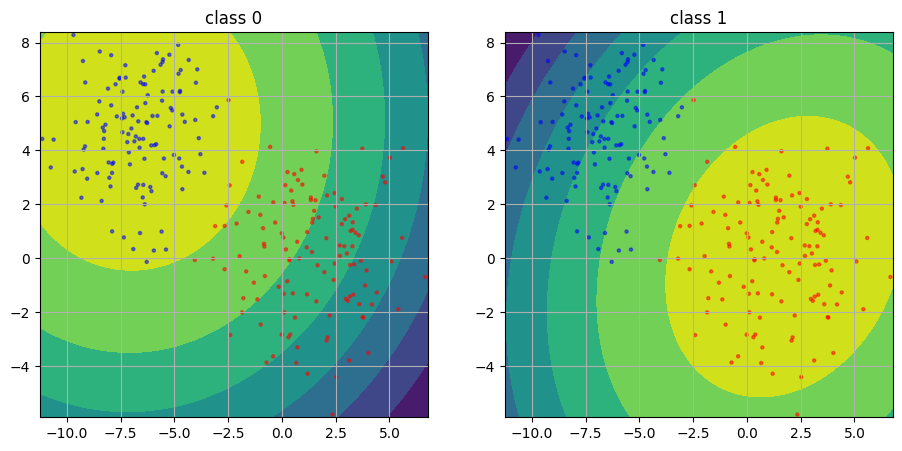

In [12]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap

# строим сетку 

n = 100 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки
display( ( xx.shape, yy.shape ) )

xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 
display( xy.shape )

score_xy = MinMaxScaler(feature_range=(0.,1.)).fit_transform( model.score(xy) )

fig,ax = plt.subplots(ncols=2,figsize=(11,5))
ax[0].contourf(xx, yy, score_xy[:,[0]].reshape(n,n),)
ax[0].scatter( x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=.5, s=5, cmap=ListedColormap(['#00f','#f00',]) )
ax[0].grid()
ax[0].set_title('class 0')

ax[1].contourf(xx, yy, score_xy[:,[1]].reshape(n,n),)
ax[1].scatter( x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=.5, s=5, cmap=ListedColormap(['#00f','#f00',]) )
ax[1].grid()
ax[1].set_title('class 1')
